In [ ]:
import pandas as pd
import matplotlib.pyplot as plt  # To visualize
import tensorflow as tf
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn import preprocessing, svm


# Read data from csv file 


In [8]:
# Datensatz von https://www.kaggle.com/lehaknarnauli/spotify-datasets?select=tracks.csv
df = pd.read_csv("tracks.csv")

# Preprocessing 

In [10]:
def label_encoding(df):
    encoder = preprocessing.LabelEncoder()
    df['name'] = encoder.fit_transform(df['name'])

    df['id_artists'] = encoder.fit_transform(df['id_artists'])

    return df

df = label_encoding(df)

df[['year', 'month', 'day']] = df['release_date'].str.split('-', expand=True)
file_name = './preprocessed_tracks.csv'

# drop elemtents that are zero
df.dropna(axis=0, inplace=True)  
df.to_csv(file_name)

# Erklärung für die Features https://rstudio-pubs-static.s3.amazonaws.com/594440_b5a14885d559413ab6e57087eddd68e6.html
# Teilen von df in Daten die Algo sehen darf (X) und das Ergebnis (y)
x_features = ['duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness',
              'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
              'valence', 'tempo', 'time_signature', 'name', 'id_artists', 'year', 'month', 'day']
X = df[x_features].copy()

y_features = 'popularity'
y = df[y_features].copy()

for col in X.columns:
    X[col] = X[col].astype(float)
    X[col] = (X[col] - X[col].min()) / (X[col].max() - X[col].min())
    
        

# create heatmap

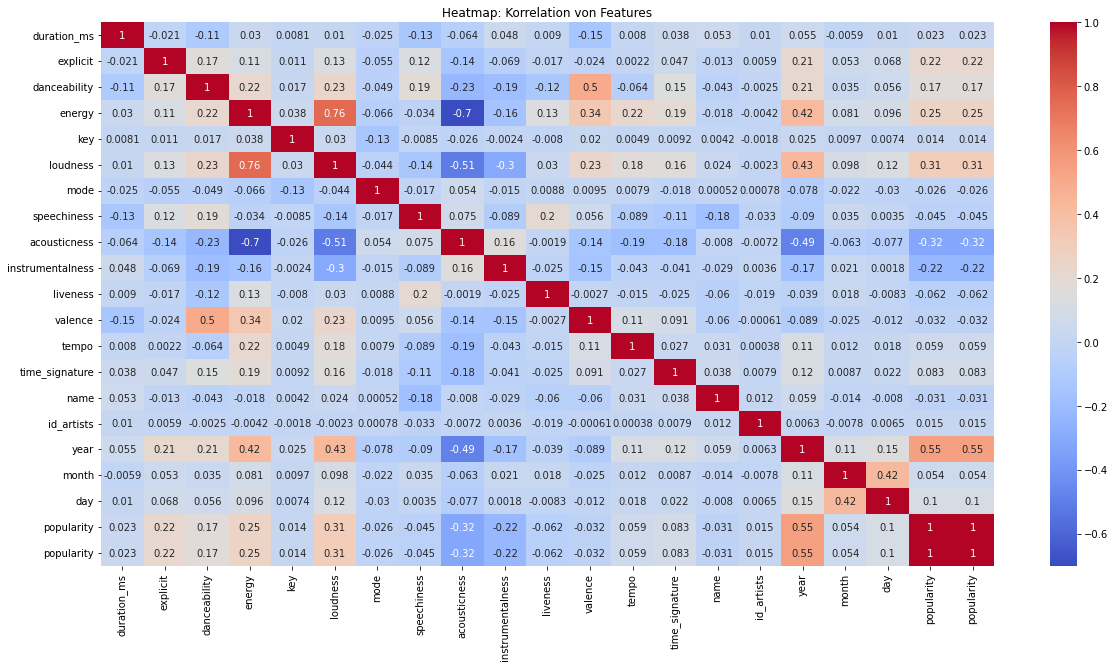

In [12]:
relevant_features = x_features
relevant_features.append('popularity')

heatmap_df = df[relevant_features]
heatmap_df.sample(frac=1)  # shuffle heatmap_df
heatmap_df = heatmap_df.apply(pd.to_numeric)
for col in heatmap_df.columns:
    heatmap_df[col] = (heatmap_df[col] - heatmap_df[col].min()) / (heatmap_df[col].max() - heatmap_df[col].min())
plt.figure(figsize=(20, 10))
heatmap = sns.heatmap(heatmap_df.corr(), cmap="coolwarm", annot=True)
plt.title("Heatmap: Korrelation von Features")
figure = heatmap.get_figure()
figure.savefig('heatmap.png', dpi=500)

# Splitting Data into train and test set

In [13]:
#  70% into train and 30% into test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, shuffle=True)

# Implementing of metrics and print output

In [14]:
# Define für die Ausgabe von mean_absolute_error auf dem Monitor
def mae(y_pred, y_test, name, name_variable, value_variable):
    mae = mean_absolute_error(y_test, y_pred)
    print(name, name_variable, " =", value_variable, " mean_absolute_error: ", mae)

# Define für die Ausgabe von mean_squared_error auf dem Monitor
def mse(y_pred, y_test, name, name_variable, value_variable):
    mse = mean_squared_error(y_test, y_pred)
    print(name, name_variable, " =", value_variable, " mean_squared_error: ", mse)

# ML-methods

## 1. LinearRegression

In [ ]:
clf = LinearRegression()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
mae(y_pred, y_test, "LinearRegression", "", "")
mse(y_pred, y_test, "LinearRegression", "", "")


## 2. SupportVectorMachine

In [ ]:
clf = svm.SVR()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
mae(y_pred, y_test, "support_vector_machine", "", "")
mse(y_pred, y_test, "support_vector_machine", "", "")

## 3. RandomForestRegressor

In [ ]:
for n_estimators in range(5, 100, 5):
    clf = RandomForestRegressor(n_estimators)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    mae(y_pred, y_test, "random_forest_regressor", "n_estimators", n_estimators)
    mse(y_pred, y_test, "random_forest_regressor", "n_estimators", n_estimators)

## 4. KNeighborsRegressor

In [ ]:
for n_neighbors in range(5, 100, 5):
    clf = KNeighborsRegressor(n_neighbors)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    mae(y_pred, y_test, "k_nearest_neighbors", "n_neighbors = ", "n_neighbors", n_neighbors)
    mse(y_pred, y_test, "k_nearest_neighbors", "n_neighbors = ", "n_neighbors", n_neighbors)

## 5. NeuralNet

In [ ]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Input(shape=(19,)))
model.add(tf.keras.layers.Dense(units=64))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dense(units=32))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dense(units=1))
model.add(tf.keras.layers.Activation('linear'))

# Compile the model
model.compile(loss=tf.keras.losses.MeanAbsoluteError(),
              optimizer="adam",
              metrics=['mae']
              )

history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=50,
                    validation_data=(X_test, y_test)
                    )
